In [1]:
# dev mode
import sys
from typing import List, Tuple

# add path
sys.path.insert(0, "../../code/src/")

# interactively load the module
%load_ext autoreload
%autoreload 2

In [2]:
from hierarchical_grouping.file_reader import BinaryPolygonFileReader, test_load_module
from hierarchical_grouping.utils import plot_two_polys
import shapely.plotting
import networkx as nx

'''
    Name,            number of sets
    data_auerberg,              796
    data_dottendorf,            871
    data_duisdorf,             2127
    data_endenich,             1060
    data_zentrum,               160
'''
file_path = "../data/data_auerberg"
reader = BinaryPolygonFileReader(file_path)

In [3]:
set_id, polys1, polys2 = reader.read_next_set()
print("set_id: ", set_id)
print("Length polys1: ", len(polys1))
print("Length polys2: ", len(polys2))

set_id:  0
Length polys1:  2
Length polys2:  28


In [4]:
set_id, polys1, polys2 = reader[7] 

# Scatter
# 3, 116, 194
# Line
# 4, 8, 15, 19, 26, 31(small leaves), 38, 43, 47, 48, 66, 76, 104, 105, 131, 141, 142, 173, 187
# Form a circle
# 62, 64, 119, 133, 134, 143, 77, 86, 92, 112, 143, 158, 159, 177
# Complicated 
# 0, 18, 37, 138, 185

# 1. Edges generation/initialization
[networkx](https://networkx.org/documentation/stable/tutorial.html)  
[Polygon](https://shapely.readthedocs.io/en/stable/reference/shapely.Polygon.html)  


## 1.1 Centroid

In [5]:
# interesting propreties of a polygon. 
# x, y coordinate don't help at all
# Area -> good

### 1.1.1 Check if two polygons are next to each others.   

In [6]:
def check_cross(polys):
    for i in range(len(polys)):
        j = i + 1
        for j in range(j, len(polys)):
            print("crossed",i,"and", j,"=",  polys[i].intersects(polys[j]))
            if polys[i].intersects(polys[j]):
                multi_poly = polys[i] | polys[j]
                print("centroid",multi_poly.centroid)

In [7]:
# check_cross(polys1)
check_cross(polys2)
# calculate unclosed polygon is not fun.
# can not calculate two polygon if they are not next to each others.

crossed 0 and 1 = True
centroid POINT (363450.3905081712 5624824.868752691)
crossed 0 and 2 = False
crossed 1 and 2 = True
centroid POINT (363449.9326202091 5624826.703924182)


### 1.1.1 Compute the centroid of the node.   
principle/formula behind it?

In [8]:
# METHOD_TYPE_NAME -> function
# TYPE_NAME -> var
def find_polys_smallest_dist_pairs(polys: List)-> tuple((List, List, List)):
    smallest_dist = float('inf')
    poly_i = None
    poly_j = None
    merged_i_j = None

    if len(polys) < 2:
        return poly_i, poly_j, merged_i_j 
        # raise ValueError("can not compared when the length is less than 2.")

    for i in range(len(polys)):
        j = i + 1
        for j in range(j, len(polys)):
            if polys[i].intersects(polys[j]):
                dist_centroid = polys[i].centroid.distance(polys[j].centroid)
                if dist_centroid < smallest_dist:
                    smallest_dist = dist_centroid
                    # print("dist", smallest_dist)
                    poly_i = polys[i]
                    poly_j = polys[j]
                    merged_i_j = polys[i] | polys[j]

    if merged_i_j == None and poly_i == None and poly_j == None:
        for i in range(len(polys)):
            j = i + 1
            for j in range(j, len(polys)):
                dist_centroid = polys[i].centroid.distance(polys[j].centroid)
                if dist_centroid < smallest_dist:
                    smallest_dist = dist_centroid
                    # print("dist", smallest_dist)
                    poly_i = polys[i]
                    poly_j = polys[j]
                    merged_i_j = polys[i] | polys[j]
    
    return poly_i, poly_j, merged_i_j

In [9]:
poly_i, poly_j, merged_i_j = find_polys_smallest_dist_pairs(polys1)
if not(poly_i == None or poly_j == None or merged_i_j == None):
    polys1.remove(poly_i)
    polys1.remove(poly_j)
    polys1.append(merged_i_j)
    print(len(polys1))

## 1.2 Init Graph and Nodes.

In [10]:
import networkx as nx
# Initialize G1 and G2
# G1 = nx.Graph()
# G2 = nx.Graph()

In [11]:
# ADD
# G1.add_nodes_from([(poly_i, {"color": "red"}), (poly_j, {"color": "green"})])
# G1.add_nodes_from([(merged_i_j, {"color": "red"})])
# G1.add_edge(merged_i_j, poly_i)
# G1.add_edge(merged_i_j, poly_j)


In [12]:
# G1.number_of_nodes()
# G1.number_of_edges() 

## 1.4 Function to calculate

In [13]:
import matplotlib.pyplot as plt

In [14]:
def algorithm_1(polys: List)-> nx.classes.graph.Graph:
    # it would be a good idea if we can use pointer here for G.
    G = nx.Graph()

    if (len(polys) == 0):
        return G
    if (len(polys) == 1):
        G.add_nodes_from([(polys[0])])
        return G

    while (len(polys) >= 2):
        poly_i, poly_j, merged_i_j = find_polys_smallest_dist_pairs(polys)

        polys.remove(poly_i)
        polys.remove(poly_j)
        polys.append(merged_i_j)

        G.add_nodes_from([(poly_i), (poly_j)])
        G.add_nodes_from([(merged_i_j)])
        G.add_edge(merged_i_j, poly_i)
        G.add_edge(merged_i_j, poly_j)

    return G

In [15]:
set_id, polys1, polys2 = reader[7] 

# Scatter
# 3, 116, 194
# Line
# 4, 8, 15, 19, 26, 31(small leaves), 38, 43, 47, 48, 66, 76, 104, 105, 131, 141, 142, 173, 187
# Form a circle
# 62, 64, 119, 133, 134, 143, 77, 86, 92, 112, 143, 158, 159, 177
# Complicated 
# 0, 18, 37, 138, 185

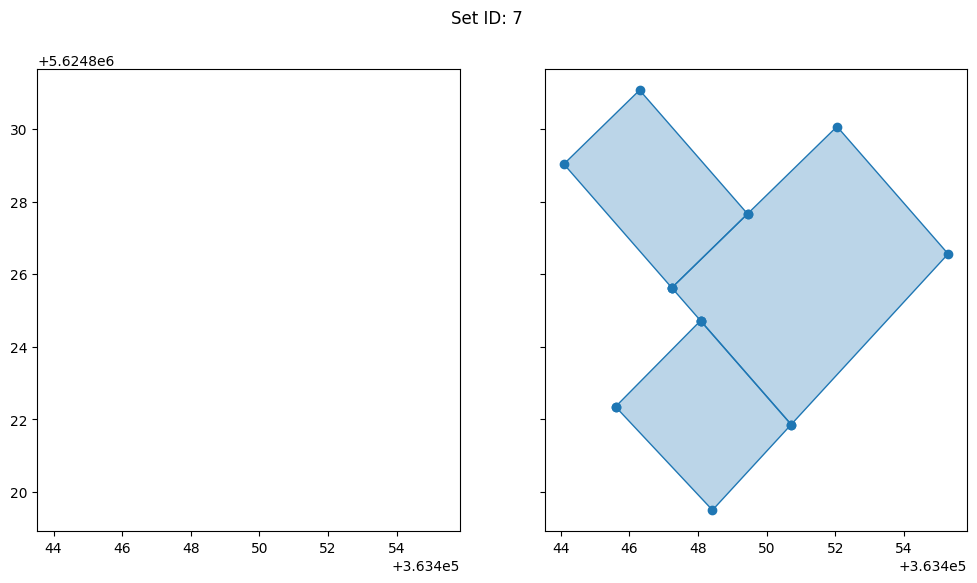

In [16]:
plot_two_polys(polys1, polys2, set_id)

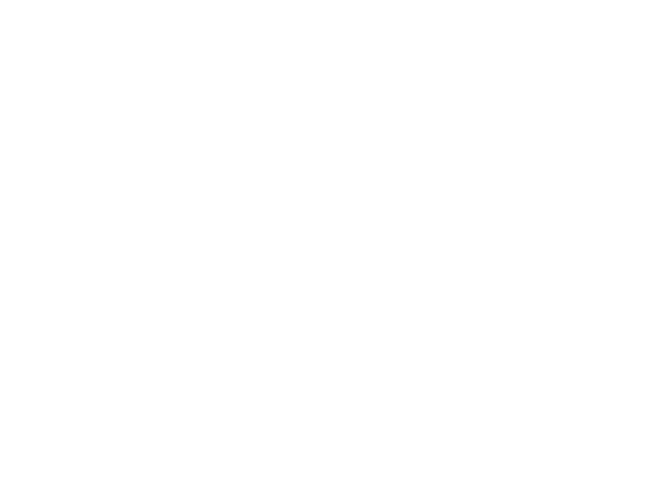

In [17]:
G1 = algorithm_1(polys1)
nx.draw(G1)

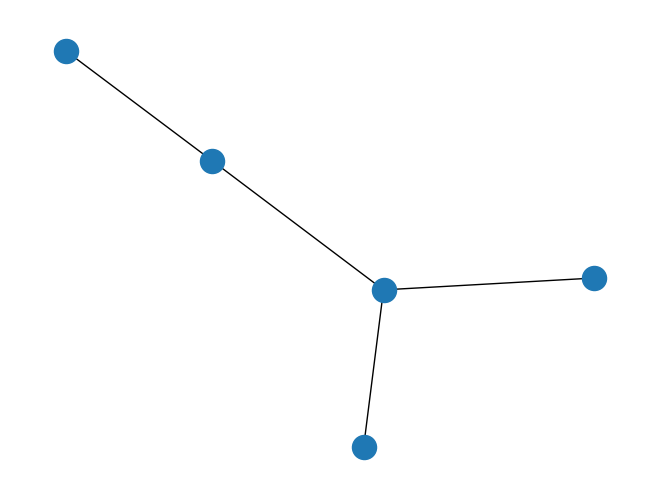

In [18]:
G2 = algorithm_1(polys2)
nx.draw(G2)

In [19]:
G1 

# test

In [20]:
import time

In [48]:
'''
    Name,            number of sets
    data_auerberg,              796
    data_dottendorf,            871
    data_duisdorf,             2127
    data_endenich,             1060
    data_zentrum,               160
'''
file_path = "../data/data_auerberg"
# file_path = "../data/data_dottendorf"
# file_path = "../data/data_duisdorf"
# file_path = "../data/data_endenich"
# file_path = "../data/data_zentrum"
reader = BinaryPolygonFileReader(file_path)

In [49]:
# set_id, polys1, polys2 = reader.read_next_set()

In [50]:
# Save timestamp
start = time.time()
while True:
    try:
        set_id, polys1, polys2 = reader.read_next_set()
        G1 = algorithm_1(polys1)
        G2 = algorithm_1(polys2)
    except:
        if G1 == None or G2 == None:
            print("last set id: ",set_id)
            print("Error")
            break
        else:
            print("last set id: ",set_id)
            print("Finish")
            break
        break
# Save timestamp
end = time.time()

print(end - start)

set id:  795
Finish
1.2651145458221436


In [ ]:
# data_auerberg   time used: 1.265
# data_dottendorf time used: 1.044
# data_duisdorf   time used: 3.367
# data_endenich   time used: 4.246
# data_zentrum    time used: 16.890